In [2]:
!pip install pyLDAvis
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')



     |████████████████████████████████| 1.6MB 3.5MB/s 
     |████████████████████████████████| 552kB 20.5MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=bfbc8eb4f9a4a364f72b856a0414f885851f8e0691939daf7ddf91a13c834d13
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=4375f77bc0d765c68c087161130e086356c086aec011a068d38120404e3fda74
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
import nltk
from nltk import sent_tokenize,word_tokenize
from nltk import regexp_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from wordcloud import WordCloud


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import plotly.graph_objects as go
import plotly.express as px
from collections import Counter

import gensim

from gensim.corpora import Dictionary
import pyLDAvis.gensim

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import LatentDirichletAllocation
from gensim import matutils, models
import scipy.sparse

import os, re, operator, warnings
warnings.filterwarnings('ignore')
%matplotlib inline

nlp = spacy.load('en')


In [4]:
# Function to load data from various file extensions
def load_data(path):
  if path.endswith(".xlsx"):
    return pd.read_excel(path)

In [5]:
train_data_df =  load_data('Training_Sheet.xlsx')
train_data_df.head()

,id,name,display_name,production_year,movie_sequel,creative_type,source,production_method,genre,language,board_rating_reason,movie_board_rating_display_name,movie_release_pattern_display_name,total,Category
0,7950115,Avatar,Avatar,2009,0,Science Fiction,Original Screenplay,Animation/Live Action,Action,English,"For intense epic battle sequences and warfare,...",PG-13,Wide,2784,9
1,50950115,Harry Potter and the Deathly Hallows: Part II,Harry Potter and the Deathly Hallows: Part II,2011,1,Fantasy,Based on Fiction Book/Short Story,Animation/Live Action,Adventure,English,for some sequences of intense action violence ...,PG-13,Wide,1328,9
2,119870115,Transformers 3,Transformers: Dark of the Moon,2011,1,Science Fiction,Based on TV,Animation/Live Action,Action,English,for intense prolonged sequences of sci-fi acti...,PG-13,Wide,1124,9
3,119590115,Toy Story 3,Toy Story 3,2010,1,Kids Fiction,Original Screenplay,Digital Animation,Adventure,English,General,G,Wide,1064,9
4,91700115,Pirates of the Caribbean 4,Pirates of the Caribbean: On Stranger Tides,2011,1,Fantasy,Based on Theme Park Ride,Live Action,Adventure,English,for intense sequences of action/adventure viol...,PG-13,Wide,1044,9


In [6]:
scoring_data_df =  load_data('Scoring_Sheet.xlsx')
score_df = scoring_data_df
scoring_data_df.head()

,id,name,display_name,production_budget,production_year,movie_sequel,creative_type,source,production_method,genre,language,board_rating_reason,movie_board_rating_display_name,movie_release_pattern_display_name
0,7970115,"Avengers, The (2011)",Marvel's The Avengers,225000000,2012,0,Super Hero,Based on Comic/Graphic Novel,Live Action,Adventure,English,for intense sequences of sci-fi violence and a...,PG-13,Wide
1,174540115,Dark Knight Rises The,The Dark Knight Rises,0,2012,1,Super Hero,Based on Comic/Graphic Novel,Live Action,Action,English,"for intense sequences of violence and action, ...",PG-13,Wide
2,149080115,Bond 23,Skyfall,200000000,2012,1,Contemporary Fiction,Based on Fiction Book/Short Story,Live Action,Action,English,"for intense violent sequences throughout, some...",PG-13,Wide
3,136020115,Twilight Saga Breaking Dawn Part 2 The,"The Twilight Saga: Breaking Dawn, Part 2",136200000,2012,1,Fantasy,Based on Fiction Book/Short Story,Live Action,Drama,English,for sequences of violence including disturbing...,PG-13,Wide
4,53500115,"Hobbit, The",The Hobbit: An Unexpected Journey,270000000,2012,1,Fantasy,Based on Fiction Book/Short Story,Animation/Live Action,Adventure,English,for extended sequences of intense fantasy acti...,PG-13,Wide


In [7]:
train_data_df.isna().sum()

id                                    0
name                                  0
display_name                          0
production_year                       0
movie_sequel                          0
creative_type                         0
source                                0
production_method                     0
genre                                 0
language                              0
board_rating_reason                   0
movie_board_rating_display_name       0
movie_release_pattern_display_name    0
total                                 0
Category                              0
dtype: int64

In [8]:
scoring_data_df.isna().sum()

id                                    0
name                                  0
display_name                          0
production_budget                     0
production_year                       0
movie_sequel                          0
creative_type                         0
source                                0
production_method                     0
genre                                 0
language                              0
board_rating_reason                   0
movie_board_rating_display_name       0
movie_release_pattern_display_name    0
dtype: int64

In [9]:
train_data_df.isnull().sum()

id                                    0
name                                  0
display_name                          0
production_year                       0
movie_sequel                          0
creative_type                         0
source                                0
production_method                     0
genre                                 0
language                              0
board_rating_reason                   0
movie_board_rating_display_name       0
movie_release_pattern_display_name    0
total                                 0
Category                              0
dtype: int64

In [10]:
scoring_data_df.isnull().sum()

id                                    0
name                                  0
display_name                          0
production_budget                     0
production_year                       0
movie_sequel                          0
creative_type                         0
source                                0
production_method                     0
genre                                 0
language                              0
board_rating_reason                   0
movie_board_rating_display_name       0
movie_release_pattern_display_name    0
dtype: int64

In [11]:
train_data_df.nunique()

id                                    1196
name                                  1196
display_name                          1195
production_year                          5
movie_sequel                             2
creative_type                            9
source                                  16
production_method                        6
genre                                   13
language                                16
board_rating_reason                   1003
movie_board_rating_display_name          6
movie_release_pattern_display_name       7
total                                  324
Category                                 9
dtype: int64

In [12]:
scoring_data_df.nunique()

id                                    91
name                                  91
display_name                          91
production_budget                     26
production_year                        1
movie_sequel                           2
creative_type                          8
source                                10
production_method                      3
genre                                  9
language                               5
board_rating_reason                   79
movie_board_rating_display_name        5
movie_release_pattern_display_name     6
dtype: int64

We observe that unique values in Id, name and display_name are unique for each row and thus we can consider dropping these columns. The unique values in other categorical columns like genre, language, source etc., differ in both train and score data, thus while one-hot encoding these features, we will have to merge these data frames

#Correlation Matrix

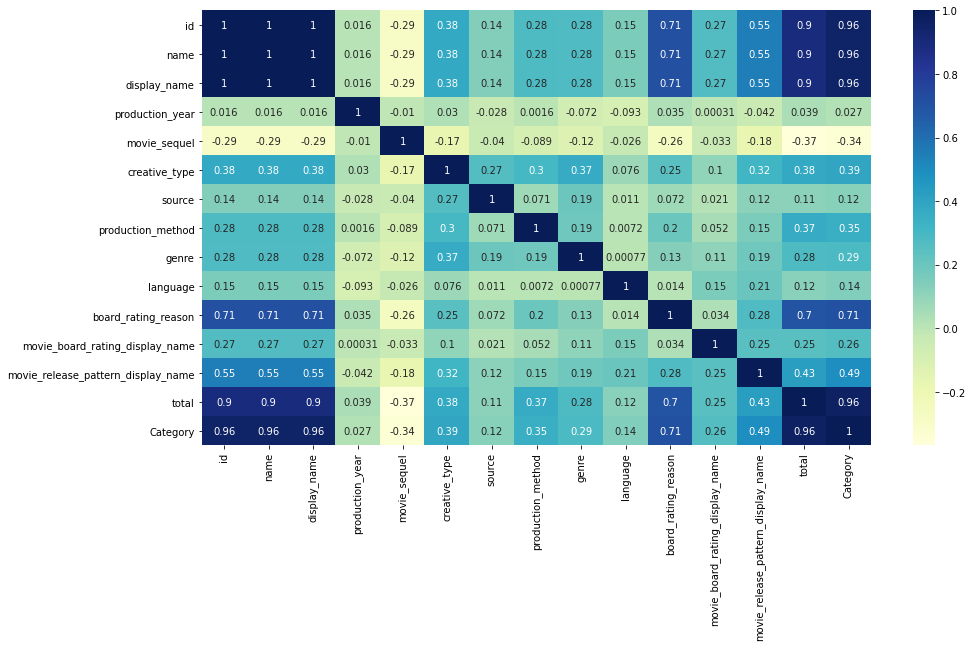

In [13]:
# function to create a correlation matrix for the given data frame
def create_correlation_matrix(df):
  corr_mat = df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
  plt.figure(figsize=(15,8))
  sns.heatmap(corr_mat, annot=True, cmap="YlGnBu")

create_correlation_matrix(train_data_df)


#Exploratory Data Analysis

In [14]:
# function to create a donut pie chart for given values and labels
def create_donut_pie(labels,values):
  fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
  fig.update_layout(autosize=False, 
                    width = 825 , height=400,  
                    paper_bgcolor="white", 
                    title = "Categorywise Distibution")
  fig.show()


## Distribution of Category
Let us observe the percentage of each target label in our data. We see that our data is highly imbalanced with less number of data points and more categories

In [15]:
# visualize the category distribution
labels, values = train_data_df['Category'].value_counts(normalize = True).index, train_data_df['Category'].value_counts(normalize = True).values
labels = ['Category ' + str(label) for label in labels]
create_donut_pie(labels, values)

In [16]:
# creating a plotly boxplot
def plotly_boxplot(df, feature1, label1, feature2, label2):
  fig = px.box(df, x=df[feature1],y = df[feature2],  color=df[feature1], 
               range_y = (-5,1500), boxmode='overlay', points="all", 
               width = 825 , height= 400,
               labels={
                     feature1: label1,
                     feature2: label2,
                 })
  return fig

# Relation between Total Gross Earnings and Category
We observe that total gross earning is linearly correlated with the Category of the Movie. Higher the earnings, Higher is the category of the Movie

In [17]:
plotly_boxplot(train_data_df, "Category","Categories", "total",'Total Gross Earnings (in Millions of $)')

In [18]:
# creating sns boxplot
def sns_box(df, feature1, feature2, col, orient,rot):
    plt.figure(figsize=(14,8))
    box = sns.boxplot(x = df[feature1],y = df[feature2], palette = col , orient=orient)
    box.set_xticklabels(box.get_xticklabels(), rotation=rot)
    return box

# Distribution of the Movie Sequel
Wee observe that the Sequel of a Movie will lie in a Category greater than 4 and the original Movie will usually be Categorized from 1 to 4

[Text(0, 0.5, 'Category'), Text(0.5, 0, 'Sequence')]

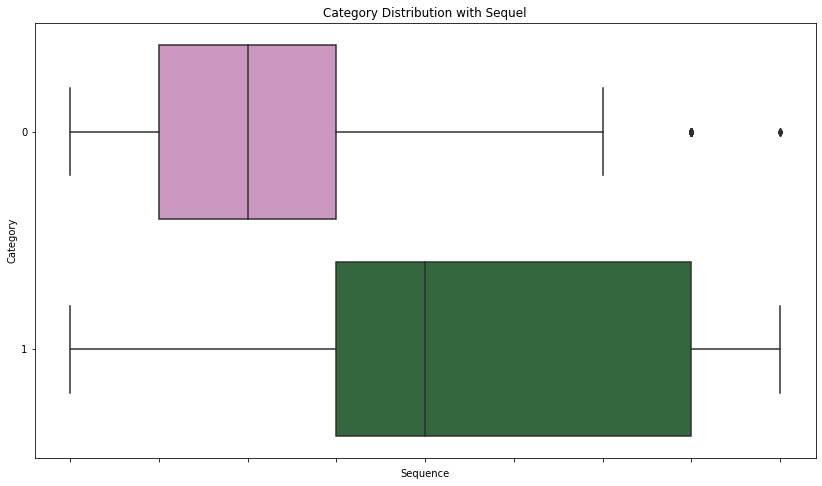

In [19]:
plot = sns_box(train_data_df, 'Category', 'movie_sequel', 'cubehelix_r','h',0)
plt.title('Category Distribution with Sequel')
plot.set(xlabel='Sequence', ylabel='Category')

#Production Method
We observe that based upon the Production method of the movie, Movies with Animation/Live Action and Digital Animation usually belong to higher category Movies from Category 6- Category 8 where as, movies with multiple production methods will be Categorized as Category 1 movies

[Text(0, 0.5, 'Category'), Text(0.5, 0, 'Production Method')]

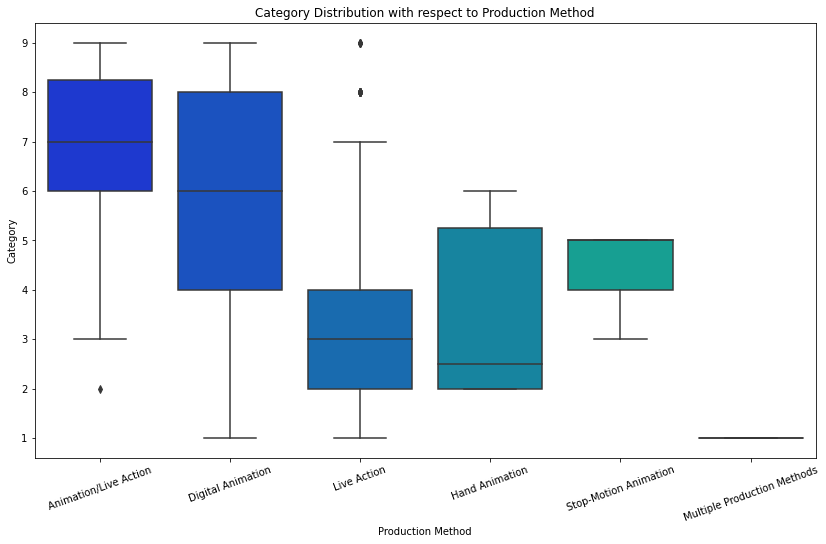

In [20]:
plot = sns_box(train_data_df, 'production_method', 'Category','winter','v',20)
plt.title('Category Distribution with respect to Production Method')
plot.set(xlabel='Production Method', ylabel='Category')

# Source

[Text(0, 0.5, 'Category'), Text(0.5, 0, 'Source')]

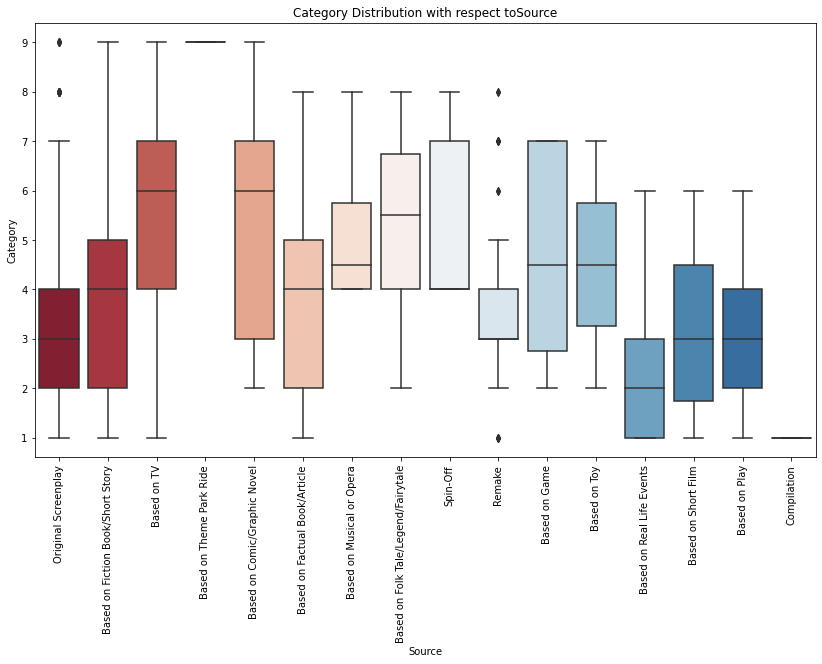

In [21]:
plot = sns_box(train_data_df, 'source', 'Category','RdBu','v',90)
plt.title('Category Distribution with respect toSource')
plot.set(xlabel='Source', ylabel='Category')


#Genre

[Text(0, 0.5, 'Category'), Text(0.5, 0, 'Genre')]

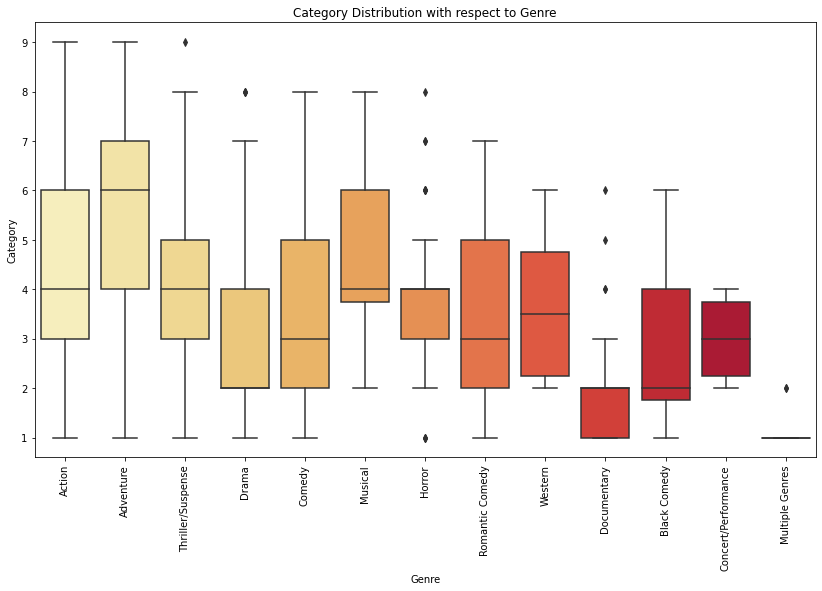

In [22]:
plot = sns_box(train_data_df, 'genre', 'Category','YlOrRd','v',90)
plt.title('Category Distribution with respect to Genre')
plot.set(xlabel='Genre', ylabel='Category')


#Analysis of Board Rating Reason
board_rating_reason is a textual feature which can be analyzed using NLP techniques

### Clean Data using Spacy
Remove stop words, punctuations, digits and other unwanted spaces

In [23]:
#clean data using spacy. Remove stop words digits punctutions and newline characters
def clean_data(text):
  skl_text = []
  for l in text:
      doc = nlp(l.lower())
      line = []
      for word in doc:
          if (word.text != '\n' and not word.is_stop and not word.is_punct and not word.is_digit and word.text != '\r' and len(word)>2 ):
              line.append(word.lemma_)
      skl_text.append(line)
  return skl_text
      

spacy_clean_train = clean_data(train_data_df['board_rating_reason'])
spacy_clean_test = clean_data(scoring_data_df['board_rating_reason'])


###Word Cloud

In [24]:
# Create String of words for word cloud
word_list = []
for row in spacy_clean_train:
    for word in row:
        word_list.append(word)
        
all_string = ', '.join(word_list)

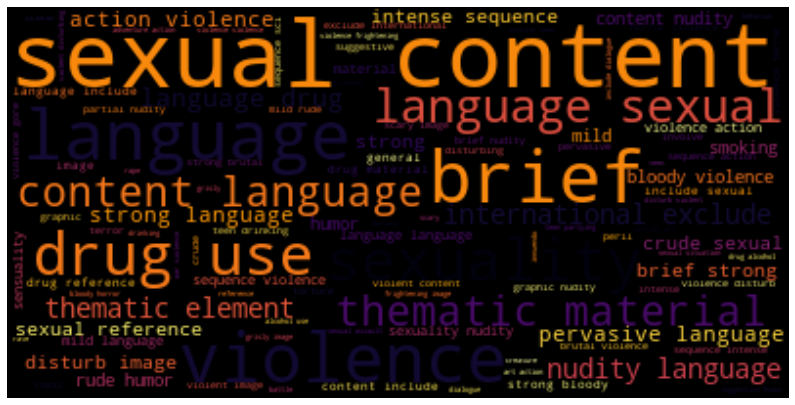

In [25]:
def create_word_cloud(data):
  stopp =stopwords.words('english')
  wc = WordCloud(stopwords=stopp, colormap="inferno",
                max_font_size=150, random_state=42)
  # sns.set(rc={'axes.facecolor':'k', 'figure.facecolor':'k'})
  plt.figure(figsize=(14,8))
  wc.generate(data)
  plt.imshow(wc, interpolation="bilinear")
  plt.axis("off")
  plt.show()

create_word_cloud(all_string)

#Most Frequently occuring words

In [26]:
word_count = pd.DataFrame(Counter(word_list).most_common(10),
                    columns=['Word', 'Frequency'])

In [27]:
# Here we use a column with categorical data
fig = px.bar(word_count, y='Word', x='Frequency',  color='Word', orientation='h',  width = 825 , height= 400)
fig.show()

#Top Bigrams

In [28]:
from nltk.collocations import BigramCollocationFinder,BigramAssocMeasures


finder = BigramCollocationFinder.from_words(word_list)
tenbest = finder.nbest(BigramAssocMeasures.likelihood_ratio,25)
tenbest

[('sexual', 'content'),
 ('international', 'exclude'),
 ('drug', 'use'),
 ('thematic', 'element'),
 ('thematic', 'material'),
 ('disturb', 'image'),
 ('intense', 'sequence'),
 ('rude', 'humor'),
 ('pervasive', 'language'),
 ('crude', 'sexual'),
 ('mature', 'thematic'),
 ('bloody', 'violence'),
 ('sexual', 'reference'),
 ('partial', 'nudity'),
 ('action', 'violence'),
 ('strong', 'bloody'),
 ('sci', 'action'),
 ('sexuality', 'nudity'),
 ('brief', 'strong'),
 ('teen', 'drinking'),
 ('graphic', 'nudity'),
 ('drug', 'reference'),
 ('exclude', 'international'),
 ('sexual', 'language'),
 ('martial', 'art')]

# Topic Modeling
After observing the word cloud and the most frequently used words, I thought to best cartegorize these reasons into 5 Topics 

In [29]:
train_df = train_data_df
train_df['spacy_clean'] = spacy_clean_train

In [30]:
bigram = gensim.models.Phrases(train_df['spacy_clean'])
texts = [bigram[line] for line in train_df['spacy_clean']]

dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [31]:

no_features = 1000

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(train_df['board_rating_reason'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(train_df['board_rating_reason'])

tf_feature_names = tf_vectorizer.get_feature_names()

no_topics = 10

# Run LDA
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.).fit(tf)

no_top_words = 10

lda1 = models.LdaModel(corpus = corpus,id2word= dictionary,num_topics=4, passes=200)
lda1.show_topics()

[(0,
  '0.120*"action" + 0.110*"sequence" + 0.110*"violence" + 0.096*"language" + 0.079*"intense" + 0.074*"mild" + 0.052*"brief" + 0.051*"humor" + 0.038*"rude" + 0.031*"sensuality"'),
 (1,
  '0.209*"thematic" + 0.121*"material" + 0.101*"international_exclude" + 0.100*"element" + 0.049*"violent" + 0.043*"mature" + 0.040*"involve" + 0.040*"language" + 0.040*"smoking" + 0.038*"image"'),
 (2,
  '0.173*"sexual" + 0.160*"content" + 0.138*"language" + 0.096*"drug" + 0.048*"nudity" + 0.047*"use" + 0.042*"reference" + 0.039*"crude" + 0.037*"include" + 0.035*"violence"'),
 (3,
  '0.165*"language" + 0.133*"violence" + 0.119*"strong" + 0.080*"sexuality" + 0.059*"brief" + 0.058*"nudity" + 0.053*"disturb" + 0.050*"image" + 0.036*"bloody" + 0.031*"graphic"')]

In [32]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda1, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.134522  0.244955       1        1  35.385929
3      0.125961 -0.016742       2        1  28.225262
0      0.099541 -0.245896       3        1  22.037067
1     -0.360024  0.017683       4        1  14.351744, topic_info=         Term        Freq       Total Category  logprob  loglift
34     sexual  369.000000  369.000000  Default  30.0000  30.0000
43   thematic  182.000000  182.000000  Default  29.0000  29.0000
35    content  342.000000  342.000000  Default  28.0000  28.0000
52     strong  203.000000  203.000000  Default  27.0000  27.0000
8      action  160.000000  160.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
110  behavior    2.362311    9.999773   Topic4  -5.9044   0.4984
55      scene    1.928578   30.854053   Topic4  -6.1072  -0.8312
113   assault    1.498610    7.777658   Topic4  -6.3595   0.2946
21    fantasy    1.418179   11.916427   Topic4  -6.4147  -0.1872
35    content    1.394831  342.778992   Topic4  -6.4313  -3.5630

[189 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
125       4  0.959330      abuse
89        4  0.957249   accident
8         3  0.994069     action
19        3  0.928620  adventure
81        1  0.964178    alcohol
...     ...       ...        ...
46        4  0.624190    violent
63        2  0.314578        war
63        3  0.707800        war
7         2  0.779752    warfare
68        3  0.676171    western

[162 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2])

# Subjectivity and Polarity
Since we had overlapping terms in 2 or more Topics, topic modelling makes a little less sense here. I thus thoght of finding the subjectivity and polarity of particular sentence and use it as a Scoring Matrix to classify the rating reason into 3 sentiments of positive, negative and neutral

In [33]:
#calculate subjectivity and polarity
from textblob import TextBlob


def calculate_sub_polarity(clean_text,data_df,feature):
    polar = lambda x : TextBlob(x).sentiment.polarity
    subject = lambda x : TextBlob(x).sentiment.subjectivity

    stopp =stopwords.words('english')

    df = pd.DataFrame()
    df['spacy_clean'] = clean_text
    df['board_rating_reason'] = data_df[feature]
    df['spacy_clean'] = df['spacy_clean'].apply(lambda x: [item for item in x if item not in stopp and len(item) >2])
    df['polarity'] = df['board_rating_reason'].apply(polar)
    df['subjectivity'] = df['board_rating_reason'].apply(subject)
    return df


train_df = calculate_sub_polarity(spacy_clean_train, train_data_df, 'board_rating_reason')
test_df = calculate_sub_polarity(spacy_clean_test, scoring_data_df, 'board_rating_reason')


Text(0.5, 1.0, 'Polarity Density')

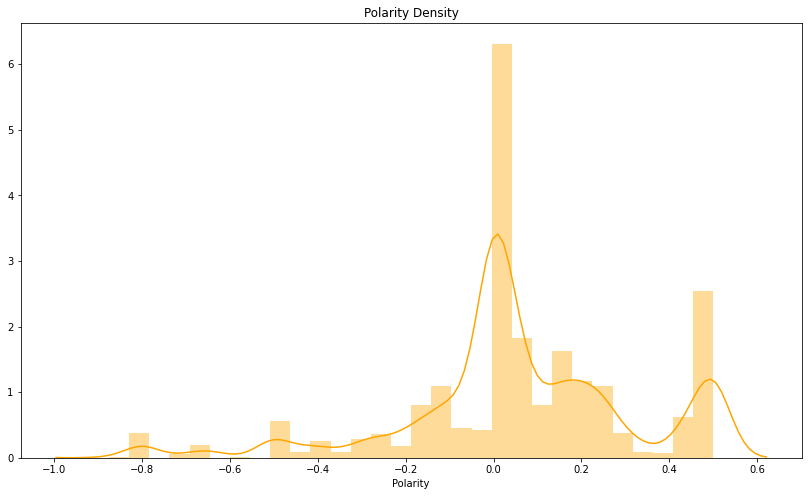

In [34]:
# Plot the polarity density of Board rating Reason
plt.figure(figsize=(14,8))
sns.distplot(train_df['polarity'], hist=True, kde=True, 
             bins=int(30), color = 'orange'
             ,axlabel ='Polarity')
# sns.set(rc={'axes.facecolor':'lightgrey', 'figure.facecolor':'lightgrey'})
plt.title('Polarity Density')


In [35]:
train_data_df = train_data_df.drop('spacy_clean',axis =1)

In [36]:
# create a categorical feature for Sentiment Score based on the Polarity score
def calculate_sentiment_score(score):
    if score >= 0.5:
        return 'positive'
    elif (score > -0.5) and (score < 0.5):
        return 'neutral'
    elif score <= -0.5:
        return 'negative'


train_data_df['Sentiment_Score']=train_df['polarity'].apply(lambda x: calculate_sentiment_score(x))
scoring_data_df['Sentiment_Score']=test_df['polarity'].apply(lambda x: calculate_sentiment_score(x))

# Data Modelling

In [37]:
train_data_df.columns

Index(['id', 'name', 'display_name', 'production_year', 'movie_sequel',
       'creative_type', 'source', 'production_method', 'genre', 'language',
       'board_rating_reason', 'movie_board_rating_display_name',
       'movie_release_pattern_display_name', 'total', 'Category',
       'Sentiment_Score'],
      dtype='object')

In [38]:
scoring_data_df.columns

Index(['id', 'name', 'display_name', 'production_budget', 'production_year',
       'movie_sequel', 'creative_type', 'source', 'production_method', 'genre',
       'language', 'board_rating_reason', 'movie_board_rating_display_name',
       'movie_release_pattern_display_name', 'Sentiment_Score'],
      dtype='object')

In [39]:
#remove unwanted columns
train_data_df = train_data_df.drop(['id','name','display_name','total','board_rating_reason'],axis = 1)
test_data_df = scoring_data_df.drop(['id','name','display_name','production_budget','board_rating_reason'],axis = 1)


In [40]:
# create a copy of all categorical variables for train and score data to prepare it for one-hot encoding
train_copy = train_data_df[['production_year','movie_sequel','creative_type','source','production_method','genre','language',
                                   'movie_board_rating_display_name','movie_release_pattern_display_name','Sentiment_Score']].copy()

test_copy = test_data_df[['production_year','movie_sequel','creative_type','source','production_method','genre','language',
                                   'movie_board_rating_display_name','movie_release_pattern_display_name','Sentiment_Score']].copy()


In [41]:
#Merging both Dataframe to ensure same number of features after one hot encoding 

train_len = len(train_copy)
merged_df = pd.concat(objs=[train_copy, test_copy], axis=0)

merged_df.shape


(1287, 10)

In [42]:
#one-hot encode

merged_encoded = pd.get_dummies(merged_df, columns=['movie_sequel','creative_type','source','production_method',
                                                 'genre','language','movie_board_rating_display_name', 'production_year',
                                                 'movie_release_pattern_display_name','Sentiment_Score'])

In [43]:
train_encoded = merged_encoded[:train_len].copy()
test_encoded = merged_encoded[train_len:].copy()

In [44]:
train_encoded.shape

(1196, 85)

In [45]:
test_encoded.shape

(91, 85)

In [46]:
# Create train and test sets
from sklearn.model_selection import train_test_split

y = train_data_df['Category']
X_train, X_test, y_train, y_test = train_test_split(train_encoded, y, test_size=0.33, random_state=40)

## Feature Importance

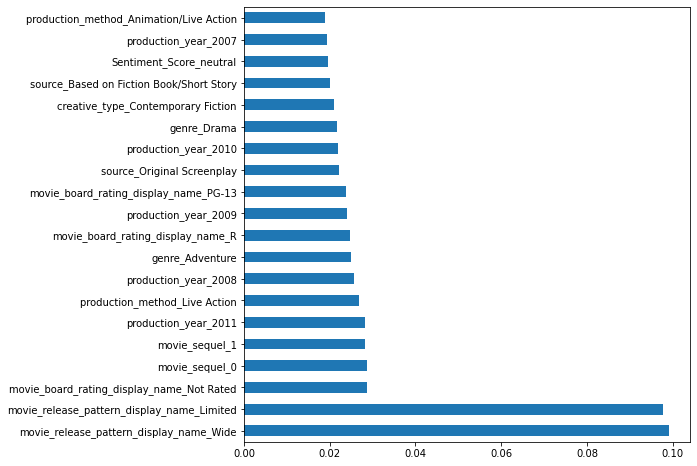

In [47]:
from sklearn.ensemble import RandomForestClassifier as RF
plt.figure(figsize=(8,8))
model =  RF(random_state= 45,max_depth=10, max_leaf_nodes=50, n_estimators=500)
model.fit(X_train,y_train)
f_imp = pd.Series(model.feature_importances_,index = X_train.columns)
f_imp.nlargest(20).plot(kind = 'barh')


In [48]:
from sklearn.metrics import confusion_matrix

#create and print confusion matrix
def print_ConfusionMatrix(actual, pred,score,algo):
  cm = confusion_matrix(actual, pred)
  plt.figure(figsize=(14,8))
  sns.set(rc={'axes.facecolor':'white','figure.facecolor':'white'})
  sns.heatmap(cm, annot=True, fmt=".2f",  cmap = 'YlOrRd');
  plt.ylabel('Actual label');
  plt.xlabel('Predicted label');
  all_sample_title = 'Accuracy Score: {0}'.format(round(score,4))
  plt.title(all_sample_title)
  plt.savefig(algo, bbox_inches='tight')

## Decision Tree

In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

clf = DecisionTreeClassifier(random_state=2,max_depth=7,min_samples_leaf=50)
scores = cross_val_score(clf, train_encoded, y, cv=5)
print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Cross Validation Accuracy: 0.25 (+/- 0.04)


## Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier as RF

clf = RF(random_state= 45,max_depth=7, max_leaf_nodes=50, n_estimators=1000)
scores = cross_val_score(clf, train_encoded, y, cv=5)
print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Cross Validation Accuracy: 0.28 (+/- 0.05)


Test-Accuracy:  0.28 


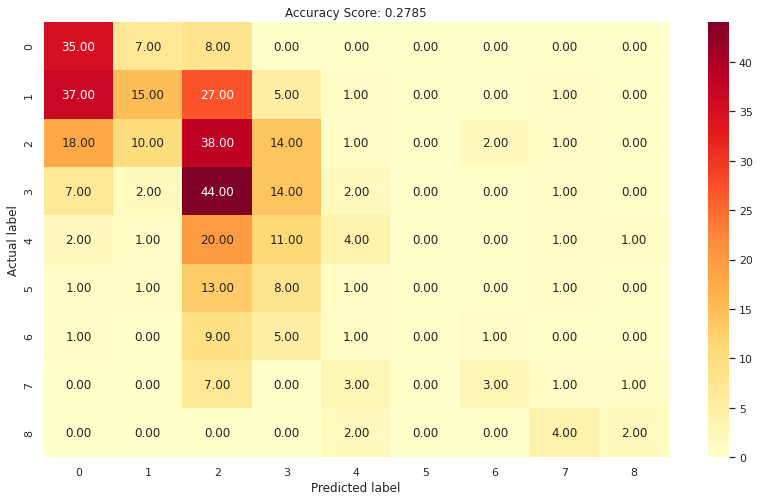

In [51]:
clf.fit(X_train, y_train)
test_predictions = clf.predict(X_test)
score = clf.score(X_test, y_test)
print_ConfusionMatrix(y_test, test_predictions,score,"Random_Forest_Confusion_Matrix.png")
print('Test-Accuracy:  %0.2f ' % score)

# Learning Curve for Random Forest

In [52]:
def plot_curve(train_scores,test_scores,train_sizes,fig_name,title,xlabel,ylabel):
  train_mean = np.mean(train_scores, axis=1)
  train_std = np.std(train_scores, axis=1)


  test_mean = np.mean(test_scores, axis=1)
  test_std = np.std(test_scores, axis=1)


  plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
  plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")


  plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
  plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

  plt.title(title)
  plt.xlabel(xlabel) 
  plt.ylabel(ylabel) 
  plt.legend(loc="best")
  plt.savefig(fig_name, bbox_inches='tight')

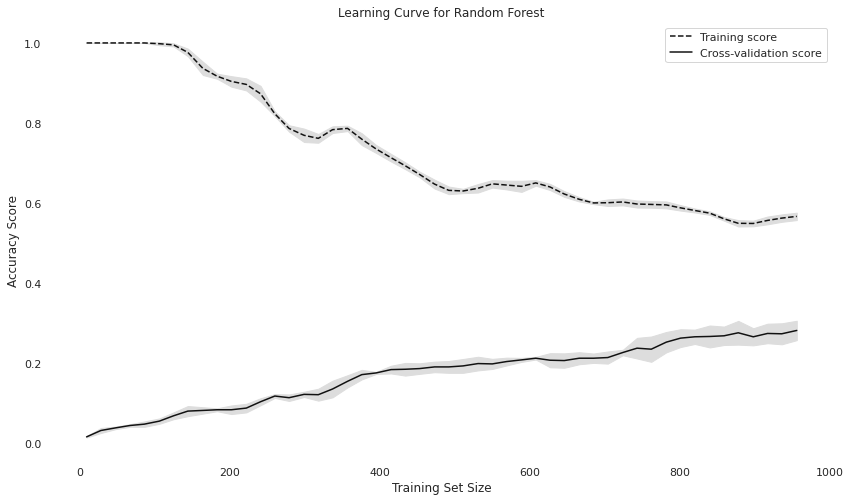

In [53]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(RF(random_state= 45,max_depth=10, max_leaf_nodes=50, n_estimators=500), 
                                                        train_encoded, 
                                                        y,
                                                        cv = 5,                                                      
                                                        scoring='accuracy',                                                       
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

plt.figure(figsize=(14,8))
plot_curve(train_scores,test_scores,train_sizes,"Random_Forest_Curve.png",
           "Learning Curve for Random Forest","Training Set Size","Accuracy Score")

# Scoring Data

In [54]:
clf = RF(random_state= 45,max_depth=10, max_leaf_nodes=50, n_estimators=500)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=50, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=45, verbose=0,
                       warm_start=False)

In [55]:
test_predictions = clf.predict(test_encoded)
test_predictions

array([7, 9, 7, 8, 9, 9, 5, 8, 5, 8, 4, 3, 7, 5, 3, 3, 5, 9, 3, 3, 7, 4,
       2, 4, 4, 4, 4, 4, 3, 3, 1, 5, 3, 3, 3, 1, 1, 3, 4, 3, 4, 3, 4, 1,
       3, 1, 1, 2, 1, 3, 1, 3, 1, 4, 3, 3, 1, 4, 2, 2, 2, 1, 1, 2, 1, 4,
       1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2])

In [56]:
scoring_data_df['Category'] = test_predictions

In [57]:
scoring_data_df.head()

,id,name,display_name,production_budget,production_year,movie_sequel,creative_type,source,production_method,genre,language,board_rating_reason,movie_board_rating_display_name,movie_release_pattern_display_name,Sentiment_Score,Category
0,7970115,"Avengers, The (2011)",Marvel's The Avengers,225000000,2012,0,Super Hero,Based on Comic/Graphic Novel,Live Action,Adventure,English,for intense sequences of sci-fi violence and a...,PG-13,Wide,neutral,7
1,174540115,Dark Knight Rises The,The Dark Knight Rises,0,2012,1,Super Hero,Based on Comic/Graphic Novel,Live Action,Action,English,"for intense sequences of violence and action, ...",PG-13,Wide,neutral,9
2,149080115,Bond 23,Skyfall,200000000,2012,1,Contemporary Fiction,Based on Fiction Book/Short Story,Live Action,Action,English,"for intense violent sequences throughout, some...",PG-13,Wide,neutral,7
3,136020115,Twilight Saga Breaking Dawn Part 2 The,"The Twilight Saga: Breaking Dawn, Part 2",136200000,2012,1,Fantasy,Based on Fiction Book/Short Story,Live Action,Drama,English,for sequences of violence including disturbing...,PG-13,Wide,neutral,8
4,53500115,"Hobbit, The",The Hobbit: An Unexpected Journey,270000000,2012,1,Fantasy,Based on Fiction Book/Short Story,Animation/Live Action,Adventure,English,for extended sequences of intense fantasy acti...,PG-13,Wide,neutral,9


In [58]:
score_df = scoring_data_df[['id','Category']].copy()
csv_file = score_df.to_csv(r'scoring_predicted_sheet.csv',index=False)

In [59]:
df = px.data.tips()
fig = px.pie(scoring_data_df, values='Category', names='Category', 
             color_discrete_sequence=px.colors.sequential.Brwnyl_r, 
             width = 825 , height=400)
fig.update_layout(title_text='Predicted Categories')
fig.show()